In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearnex import patch_sklearn

patch_sklearn()

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from keras.layers import Dense
from keras.models import Sequential
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             recall_score)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


### Importação e análise dos conjuntos de dados

In [2]:
SELECTED_DATABASE = "cmmd"

try:
    breast_cancer_df = pd.read_csv(f"../../outputs/mamografia/{SELECTED_DATABASE}/glcm_features_{SELECTED_DATABASE}.csv")
except FileNotFoundError:
    raise Exception("Database not found!")

""" columns = ['correlation_dist_1_ang_0', 'homogeneity_dist_1_ang_90', 'ASM_dist_1_ang_135', 'ASM_dist_3_ang_0', 'pathology']
breast_cancer_df = breast_cancer_df[columns] """

breast_cancer_df.head()

,dissimilarity_dist_1_ang_0,dissimilarity_dist_1_ang_45,dissimilarity_dist_1_ang_90,dissimilarity_dist_1_ang_135,correlation_dist_1_ang_0,correlation_dist_1_ang_45,correlation_dist_1_ang_90,correlation_dist_1_ang_135,homogeneity_dist_1_ang_0,homogeneity_dist_1_ang_45,...,contrast_dist_1_ang_135,ASM_dist_1_ang_0,ASM_dist_1_ang_45,ASM_dist_1_ang_90,ASM_dist_1_ang_135,energy_dist_1_ang_0,energy_dist_1_ang_45,energy_dist_1_ang_90,energy_dist_1_ang_135,pathology
0,2.075772,2.359203,2.076464,2.339205,0.921239,0.910521,0.921237,0.911280,0.991860,0.990748,...,596.497346,0.888572,0.887438,0.888538,0.887515,0.942641,0.942039,0.942623,0.942080,benign
1,6.714374,7.479016,6.518917,7.477504,0.880830,0.867279,0.884366,0.867306,0.973670,0.970671,...,1906.763602,0.753409,0.750545,0.754010,0.750550,0.867992,0.866340,0.868337,0.866343,benign
2,3.079869,3.500815,3.112198,3.501512,0.916047,0.904611,0.915230,0.904592,0.987922,0.986272,...,892.885624,0.844202,0.842536,0.843971,0.842534,0.918805,0.917898,0.918679,0.917896,benign
3,5.621605,6.388154,5.508748,6.338683,0.908092,0.895563,0.909960,0.896371,0.977955,0.974949,...,1616.364163,0.738577,0.735704,0.738937,0.735888,0.859405,0.857732,0.859614,0.857839,benign
4,7.789710,8.943788,7.763529,8.893910,0.879019,0.861145,0.879496,0.861920,0.969453,0.964927,...,2267.946977,0.717883,0.713564,0.717832,0.713746,0.847280,0.844727,0.847250,0.844835,benign


Visualizar a frequência das classes

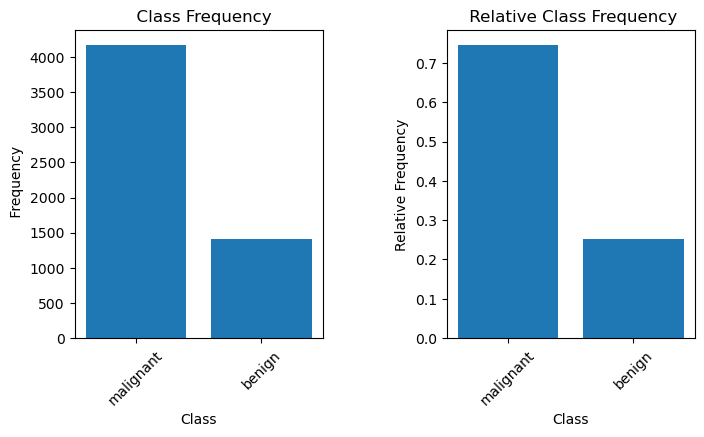

In [3]:
fig = plt.figure(figsize=(8, 4))
titles = ['', 'Relative']

for i, title in enumerate(titles, start=1):
    isRelative = True if i == 2 else False
    frequency = breast_cancer_df['pathology'].value_counts(normalize=isRelative)
    plt.subplot(1, 2, i)
    plt.bar(frequency.index, frequency)
    plt.title(f' {title} Class Frequency')
    plt.xlabel('Class'), plt.ylabel(f'{title} Frequency')
    plt.xticks(rotation=45)
fig.subplots_adjust(wspace=0.5)
plt.show()

### Pré-Processamento

In [4]:
# Elimina os dados com classe BENIGN_WITHOUT_CALLBACK ou NORMAL
breast_cancer_df = breast_cancer_df[breast_cancer_df["pathology"] != "benign_without_callback"]
breast_cancer_df = breast_cancer_df[breast_cancer_df["pathology"] != "normal"]

# Elimina os dados com valores nulos
breast_cancer_df.dropna(inplace=True)

# Separa em features e labels
X, y = (breast_cancer_df.drop(["pathology"], axis=1), breast_cancer_df["pathology"])

# Tratamos os rótulos categóricos
y = y.map({"benign": 0, "malignant": 1})

if SELECTED_DATABASE in ["inbreast", "mias"]:
    smote = SMOTE()
    X, y = smote.fit_resample(X, y)
elif SELECTED_DATABASE == "cmmd":
    nearmiss = NearMiss(version=1)
    X, y = nearmiss.fit_resample(X, y)

# Separa os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)

# Padroniza os dados
for col in X_train.columns:
    scaler = MinMaxScaler()
    X_train[col] = scaler.fit_transform(X_train[col].values.reshape(-1, 1))
    X_test[col] = scaler.transform(X_test[col].values.reshape(-1, 1))

##### Visualizar Dados após pré-processamento 

In [5]:
X_train.head()

,dissimilarity_dist_1_ang_0,dissimilarity_dist_1_ang_45,dissimilarity_dist_1_ang_90,dissimilarity_dist_1_ang_135,correlation_dist_1_ang_0,correlation_dist_1_ang_45,correlation_dist_1_ang_90,correlation_dist_1_ang_135,homogeneity_dist_1_ang_0,homogeneity_dist_1_ang_45,...,contrast_dist_1_ang_90,contrast_dist_1_ang_135,ASM_dist_1_ang_0,ASM_dist_1_ang_45,ASM_dist_1_ang_90,ASM_dist_1_ang_135,energy_dist_1_ang_0,energy_dist_1_ang_45,energy_dist_1_ang_90,energy_dist_1_ang_135
975,0.413191,0.428243,0.411982,0.417059,0.472674,0.454131,0.484821,0.461243,0.586809,0.571757,...,0.411982,0.417059,0.361968,0.360012,0.362075,0.363135,0.404189,0.403074,0.404240,0.406511
2015,0.161286,0.165730,0.168180,0.165181,0.604055,0.592638,0.598004,0.590630,0.838714,0.834270,...,0.168180,0.165181,0.744638,0.744051,0.743749,0.744693,0.775191,0.775236,0.774343,0.775950
1767,0.148245,0.151256,0.151176,0.150520,0.562623,0.552553,0.566384,0.551884,0.851755,0.848744,...,0.151176,0.150520,0.808938,0.808045,0.808884,0.808578,0.833293,0.832949,0.833215,0.833526
412,0.159668,0.159750,0.164134,0.157659,0.612329,0.611257,0.611745,0.613043,0.840332,0.840250,...,0.164134,0.157659,0.740723,0.741159,0.740327,0.742171,0.771619,0.772603,0.771219,0.773655
1342,0.201720,0.203711,0.204840,0.200773,0.574612,0.570146,0.578211,0.571976,0.798280,0.796289,...,0.204840,0.200773,0.678720,0.678785,0.678493,0.680011,0.714485,0.715237,0.714228,0.716529


In [6]:
y_train.head()

975     0
2015    1
1767    1
412     0
1342    0
Name: pathology, dtype: int64

##### Visualizar frequência de classe em cada parte do conjunto de dados

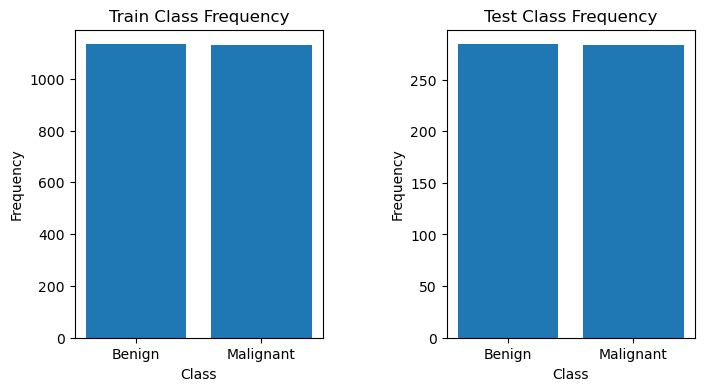

In [7]:
fig = plt.figure(figsize=(8, 4))
y_parts = [y_train, y_test]
idxs = [1, 2]
titles = ['Train', 'Test']

for i, y_part, title in zip(idxs, y_parts, titles):
    frequency = y_part.value_counts()
    frequency.index = ['Benign', 'Malignant']
    
    plt.subplot(1, 2, i)
    plt.bar(frequency.index, frequency)
    plt.title(f'{title} Class Frequency')
    plt.xlabel('Class'), plt.ylabel('Frequency')
fig.subplots_adjust(wspace=0.5)
plt.show()

### Treinamento dos modelos

##### Funções

In [8]:
# Função para criar o modelo do Keras
def create_mlp_model(shape):
    model = Sequential()
    model.add(Dense(25, input_dim=shape, activation="relu"))
    model.add(Dense(50, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
    return model

##### Treino dos modelos

In [9]:
# Models
random_forest_model = RandomForestClassifier(n_estimators=120, max_depth=10, criterion="gini", 
                                             min_samples_leaf=3, min_samples_split=2)
boosted_tree_model = GradientBoostingClassifier(learning_rate=0.1, max_depth=3, n_estimators=100)
mlp_model = create_mlp_model(X_train.shape[1])

threshold = 0.5
titles = ["Random Forest", "Boosted Tree", "MLP"]
models = [random_forest_model, boosted_tree_model, mlp_model]
scores = {}

for model, title in zip(models, titles):
    predict = []
    if title == "MLP":
        model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=0)
        predict = model.predict(X_test)
        predict = (predict > threshold).astype(int) # Transformar as saídas em rótulos
    else:
        model.fit(X_train, y_train)
        predict = model.predict(X_test)

    scores[title] = {"accuracy_score": accuracy_score(y_test, predict) * 100}
    scores[title]["precision_score"] = precision_score(y_test, predict) * 100
    scores[title]["recall_score"] = recall_score(y_test, predict) * 100
    scores[title]["f1_score"] = f1_score(y_test, predict) * 100

""" for model, title in zip(models, titles):
    # Define the forward selection object
    sfs = SFS(model, k_features=(1, X_train.shape[1]), forward=True, floating=False, scoring="accuracy", cv=5)

    # Perform forward selection on the training set
    sfs.fit(X_train, y_train)

    # Print the selected features
    print(f"{title} Selected Features:", sfs.k_feature_names_)
    accuracy = sfs.k_score_
    print("Accuracy:", accuracy) """

18/18 [==============================] - 0s 943us/step


' for model, title in zip(models, titles):\n    # Define the forward selection object\n    sfs = SFS(model, k_features=(1, X_train.shape[1]), forward=True, floating=False, scoring="accuracy", cv=5)\n\n    # Perform forward selection on the training set\n    sfs.fit(X_train, y_train)\n\n    # Print the selected features\n    print(f"{title} Selected Features:", sfs.k_feature_names_)\n    accuracy = sfs.k_score_\n    print("Accuracy:", accuracy) '

### Avaliação dos modelos

In [10]:
scores_df = pd.DataFrame(scores).T
scores_df

,accuracy_score,precision_score,recall_score,f1_score
Random Forest,64.197531,61.111111,77.738516,68.429238
Boosted Tree,64.902998,61.731844,78.091873,68.954758
MLP,64.197531,59.090909,91.872792,71.922545


In [12]:
result = [[68.959436, 65.255732, 68.959436], [65.255732, 68.253968, 67.901235],
          [64.197531, 64.902998, 64.197531]]

columns=['Random Forest', 'Boosted Tree', 'MLP']
df = pd.DataFrame(result, columns=columns)

def mean_without_extremes(df):
    new_df = pd.DataFrame(columns=df.columns)
    for col in df.columns:
        df.sort_values(by=col, inplace=True)
        df[col] = df[col].drop(df[col].index[[0, -1]])
        new_df[col] = [df[col].mean()]
    return new_df

df = mean_without_extremes(df)
df

,Random Forest,Boosted Tree,MLP
0,65.255732,65.255732,67.901235
